In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = 'cuda:1'


BUILDER = 'attention'
builder_name = "Multihead Attention"

LR = 3e-4
EPOCHS = 15



exp_name = 'shuffle_4_MULTIHEAD_ATTENTION_06_04_22'
model_filename = f'/adjacency_builders/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE, #32
        num_workers=4,
        shuffle=True,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

#### Model

In [13]:
from torchvision import models

In [14]:
torch.cuda.empty_cache()

In [15]:
model = GATConvGNN(7, 1024, 2, 4, 0.7, device, adjacency_builder = BUILDER).to(device)

In [16]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [17]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification - shuffle",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [18]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 282/282 [00:17<00:00, 15.87it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 61.04% Train Loss: 2.1964 Test acc: 70.27% Test Loss: 1.6646


100%|██████████| 282/282 [00:17<00:00, 15.76it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 85.64% Train Loss: 0.8274 Test acc: 74.28% Test Loss: 1.4484


100%|██████████| 282/282 [00:17<00:00, 15.91it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 88.88% Train Loss: 0.6696 Test acc: 74.76% Test Loss: 1.4537


100%|██████████| 282/282 [00:17<00:00, 15.85it/s]


Saved best parameters at epoch 4
EPOCH 4: Train acc: 90.55% Train Loss: 0.5739 Test acc: 75.59% Test Loss: 1.4241


100%|██████████| 282/282 [00:17<00:00, 15.79it/s]


EPOCH 5: Train acc: 92.19% Train Loss: 0.4680 Test acc: 75.08% Test Loss: 1.4638


100%|██████████| 282/282 [00:17<00:00, 15.83it/s]


EPOCH 6: Train acc: 93.17% Train Loss: 0.4208 Test acc: 73.79% Test Loss: 1.5211


100%|██████████| 282/282 [00:17<00:00, 15.78it/s]


EPOCH 7: Train acc: 94.10% Train Loss: 0.3649 Test acc: 75.16% Test Loss: 1.4794


100%|██████████| 282/282 [00:17<00:00, 15.88it/s]


EPOCH 8: Train acc: 94.97% Train Loss: 0.3137 Test acc: 75.17% Test Loss: 1.5030


100%|██████████| 282/282 [00:17<00:00, 15.80it/s]


EPOCH 9: Train acc: 95.70% Train Loss: 0.2769 Test acc: 74.08% Test Loss: 1.5396


100%|██████████| 282/282 [00:17<00:00, 15.77it/s]


EPOCH 10: Train acc: 96.64% Train Loss: 0.2205 Test acc: 74.50% Test Loss: 1.5748


100%|██████████| 282/282 [00:17<00:00, 15.81it/s]


Saved best parameters at epoch 11
EPOCH 11: Train acc: 97.75% Train Loss: 0.1583 Test acc: 75.69% Test Loss: 1.5087


100%|██████████| 282/282 [00:17<00:00, 15.95it/s]


EPOCH 12: Train acc: 98.18% Train Loss: 0.1366 Test acc: 74.73% Test Loss: 1.5419


100%|██████████| 282/282 [00:17<00:00, 15.85it/s]


EPOCH 13: Train acc: 98.71% Train Loss: 0.1019 Test acc: 75.52% Test Loss: 1.5125


100%|██████████| 282/282 [00:17<00:00, 15.95it/s]


EPOCH 14: Train acc: 98.85% Train Loss: 0.1004 Test acc: 75.57% Test Loss: 1.5086


100%|██████████| 282/282 [00:17<00:00, 15.81it/s]

EPOCH 15: Train acc: 98.75% Train Loss: 0.0993 Test acc: 75.06% Test Loss: 1.5431


In [19]:
wandb.finish()

test/test_accuracy,▁▆▇█▇▆▇▇▆▆█▇██▇
test/test_loss,█▂▂▁▂▄▃▃▄▅▃▄▄▃▄
train/train_accuracy,▁▆▆▆▇▇▇▇▇██████
train/train_loss,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test/test_accuracy,0.75056
test/test_loss,1.54312
train/train_accuracy,0.9875
train/train_loss,0.09926


In [20]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [21]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 15.76it/s]


In [22]:
accuracy_score(test_targets, test_preds)

0.7551111111111111

---

### Accuracy per class and confusion matrix

In [23]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [24]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [25]:
class_acc

{'1_cumulus': 0.6386666666666667,
 '2_altocumulus': 0.43066666666666664,
 '3_cirrus': 0.896414342629482,
 '4_clearsky': 0.9773442416614223,
 '5_stratocumulus': 0.6631284916201118,
 '6_cumulonimbus': 0.8134733792104311,
 '7_mixed': 0.5485996705107083}

Global Test accuracy 0.7551111111111111


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

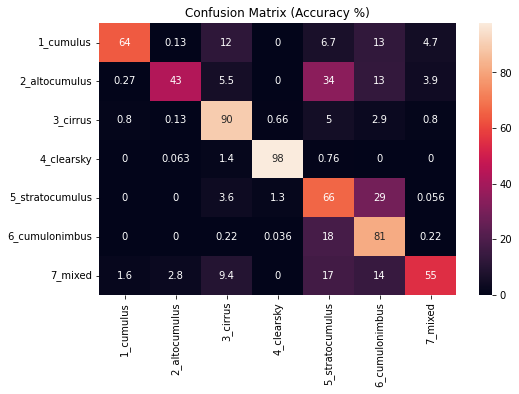

In [26]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)